### Each level of complexity is plotted separately ###

read
plot


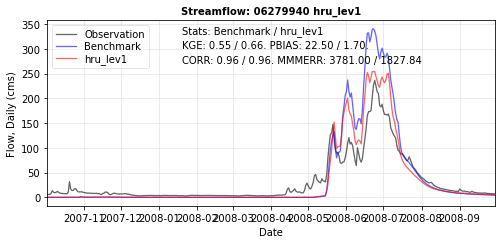

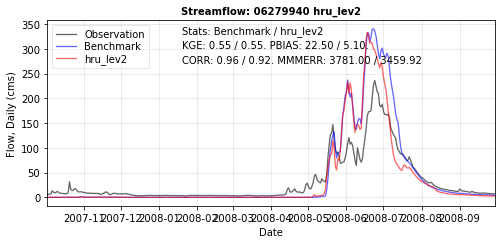

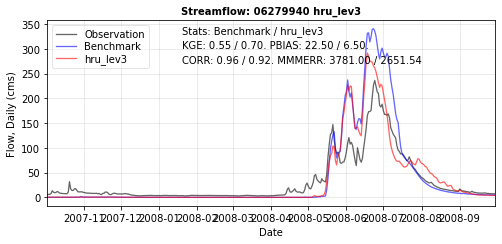

save
Done


In [2]:
# compare route outputs from different levels of complexity
import os, datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from PIL import Image

# ========== User settings ==================================
root_dir='/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/calib'
basinName='06279940'

# hru inputs
level_num=3               # total number of discretization complexities
label_basename='hru_lev'  # label basename for spatial discretization

# observation inputs
obsFile=os.path.join(root_dir,'obs','obs_flow.'+basinName+'.cfs.csv') # obs file path
obsVoid=-9999.0 # missing value of obsFile

# calib inputs
calib_run = 1                   # calibration run number. eg 1,2,3
sim_date_start = '2007-10-01'   # route sim start date used to specify route ofile

# plot inputs
time_format = '%Y-%m-%d'
plot_date_start = '2007-10-01'
plot_date_end = '2008-09-30'
plot_date_start_obj = datetime.datetime.strptime(plot_date_start, time_format)
plot_date_end_obj = datetime.datetime.strptime(plot_date_end, time_format)

output_dir=os.path.join(root_dir,basinName,'analysis/5c_compare_level_sim')
ofile = 'compare_sim_'+basinName+'.png'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# ========== end User settings ==================================

# --- read observed flow from CSV file (cfs)
df_obs = pd.read_csv(obsFile, header=0, sep=',', index_col=0, parse_dates=[0],
                     keep_default_na=False, na_values=[obsVoid])
df_obs = df_obs.apply(pd.to_numeric, errors='coerce')   # convert 'str' data column to float
df_obs.rename(columns={df_obs.columns[0]:'Observed'}, inplace=True)
df_obs['Observed'] = df_obs['Observed'].div(35.315)    # convert to m^3/s

# --- read summa simulated output
print('read')
q_dic = {}
stat_dic = {}
for level_id in range(level_num+1):
    label=label_basename+str(level_id)
    
    # (1) read route output
    q_ncfile = os.path.join(root_dir,basinName,label,'out_archive', str(calib_run),
                            'sflow.'+label+'.h.'+sim_date_start+'-00000.nc')
    ds = xr.open_dataset(q_ncfile) 
    time = ds['time'].values[:]
    time = pd.to_datetime(time)
    q =  ds['IRFroutedRunoff'].values[:] #(time, gru)

    df = pd.DataFrame(q, index=time)
    q_dic[label]=df

    # (2) read statistics
    diag_path = os.path.join(root_dir,basinName,label,'out_archive', str(calib_run), 'trial_stats.txt')
    stat = np.loadtxt(diag_path,usecols=[0],dtype='float', delimiter='#')
    stat_dic[label] = stat #0KGE,1NSE,2RMSE,3PBIAS,4CORR,5MMMERR
    
# --- plot summa simulated output
print('plot')
seg_id = 10
fontsize = 'medium' #'large'
fig_file_summary = []

for level_id in range(1,level_num+1):
# for level_id in range(1,1+1):
    label=label_basename+str(level_id)    
    fig, ax = plt.subplots(1,1,figsize=[7.08, 3.5]) #figsize=[7.08*2, 7.08*0.6]
    
    # ===========================================================================
    # plot obs flow
    df_obs_cut = df_obs.truncate(before=plot_date_start_obj, after=plot_date_end_obj)
    ax.plot_date(df_obs_cut.index, df_obs_cut['Observed'], color='k', linestyle='-', linewidth=1.3, 
                 markersize=0.0, alpha=0.6, label='Observation')

    # plot level0 sim flow
    label0=label_basename+str(0)
    df = q_dic[label0]
    df_cut = df.truncate(before=plot_date_start_obj, after=plot_date_end_obj)
    ax.plot_date(df_cut.index, df_cut[seg_id], color='b', linestyle='-', 
                 linewidth=1.3, markersize=0.0, alpha=0.6, label='Benchmark')
    
    # plot another level sim flow
    df = q_dic[label]
    df_cut = df.truncate(before=plot_date_start_obj, after=plot_date_end_obj)
    ax.plot_date(df_cut.index, df_cut[seg_id], color='r', linestyle='-', 
                 linewidth=1.3, markersize=0.0, alpha=0.6, label=label)

    # ===========================================================================
    # plot diagnostics
    stat0 = stat_dic[label0] #0KGE,1NSE,2RMSE,3PBIAS,4CORR,5MMMERR
    stat = stat_dic[label]
    ax.annotate('Stats: Benchmark / %s'%(label), (0.3,0.93), xycoords='axes fraction', fontsize=fontsize)
    ax.annotate('KGE: %.2f / %.2f. PBIAS: %.2f / %.2f.'%(stat0[0],stat[0],stat0[3],stat[3]), (0.3,0.85), xycoords='axes fraction', fontsize=fontsize)
    ax.annotate('CORR: %.2f / %.2f. MMMERR: %.2f / %.2f'%(stat0[4],stat[4],stat0[5],stat[5]), (0.3,0.77), xycoords='axes fraction', fontsize=fontsize) # (Pearson correlation)

    # ===========================================================================
    # others
    ax.set_title('Streamflow: ' + basinName + ' '+label,fontsize=fontsize,weight='semibold')
    ax.set_xlim(df_cut.index[0],df_cut.index[-1])
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_tick_params(labelsize=fontsize)#rotation=30,

    ax.set_xlabel('Date', fontsize=fontsize)
    ax.set_ylabel('Flow, Daily (cms)', fontsize=fontsize)
    ax.tick_params(direction='out', labelsize=fontsize)
    ax.grid(True,linewidth=0.5,alpha=0.5)
    
    ax.legend(loc='upper left', fontsize=fontsize, framealpha=0.5,labelspacing=0.2) 
#     if level_id == level_num:
#         ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),fontsize=fontsize, framealpha=0.5,ncol=3)

    fig.tight_layout()
    ofile = 'compare_sim_'+basinName+'_'+label+'.png'
    plt.savefig(os.path.join(output_dir,ofile), dpi=80)
    fig_file_summary.append(os.path.join(output_dir,ofile)) 
    
    plt.show()
    plt.close(fig)
    
# --- merge and save as one figure
print('save')
widths = []
heights = []
for fig_file in fig_file_summary:
    im = Image.open(fig_file)
    widths.append(im.width)
    heights.append(im.height)

col_num = 1
row_num = len(fig_file_summary)

total_width = int(max(widths)*col_num)
total_height = int(max(heights)*row_num)
new_im = Image.new('RGB', (total_width, total_height))

for col in range(col_num):
    for row in range(row_num):
        k = row*col_num+col
        fig_file = fig_file_summary[k]
        im = Image.open(fig_file)   

        x_offset_width = im.size[0]
        x_offset_height = im.size[1]
        new_im.paste(im, (x_offset_width*col,x_offset_height*row))

ofile = 'compare_sim_'+basinName+'.png'
new_im.save(os.path.join(output_dir,ofile))

print('Done')

$$PBIAS = 100 \frac{ \sum_{i=1}^N { \left( S_i - O_i \right) } } { \sum_{i=1}^N O_i} $$